In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
matrix = np.load("/home/denis/code/mask_model/numpy_data/frame_0.npy")

In [5]:
matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

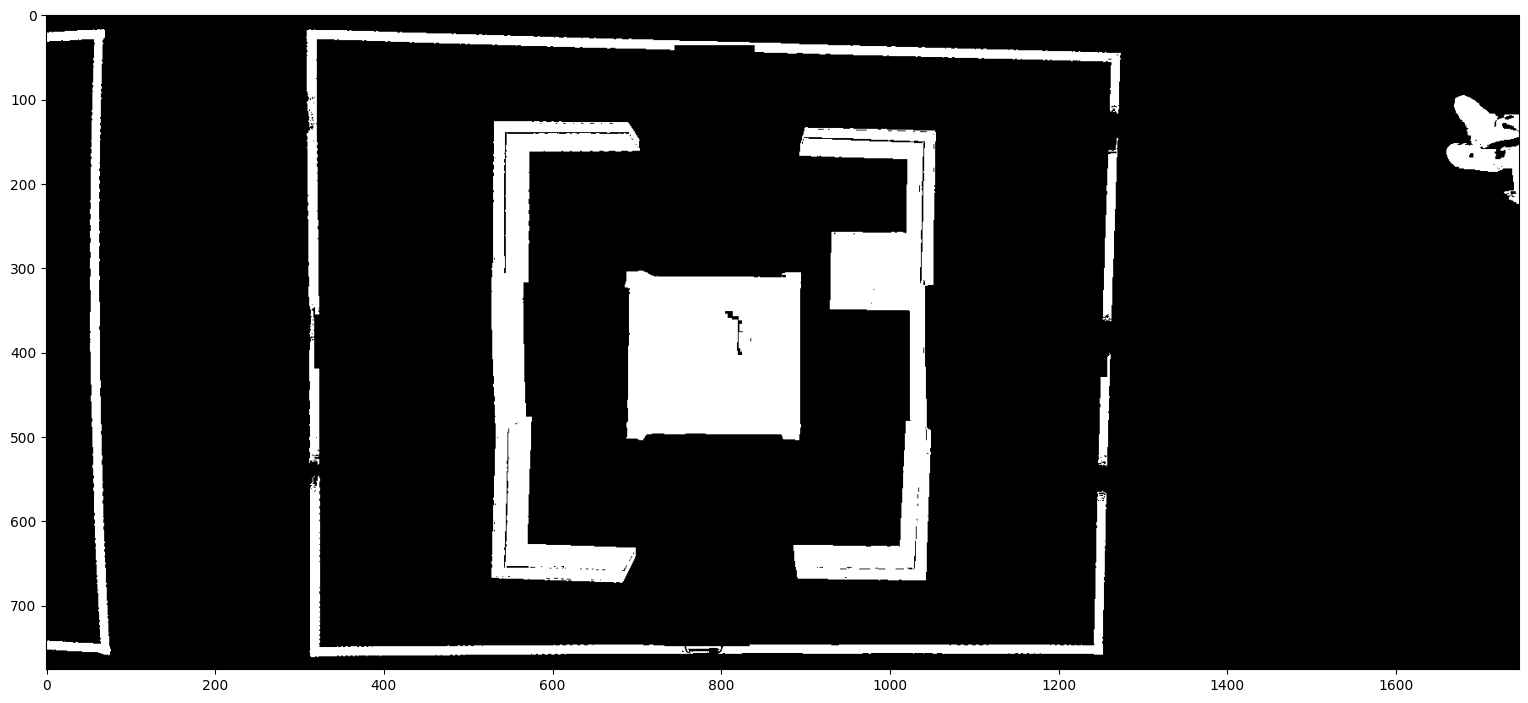

In [6]:
plt.figure(figsize=(19, 19))
plt.imshow(matrix, cmap='gray')
plt.show()

In [7]:
kernel_size = (150, 200)

In [8]:
def find_cube(image, kernel_size=kernel_size, threshold=0.96):
    """
    Ищет на изображении область, где процент вхождений 1 в заданном окне равен 95%.
    
    :param image: Входное изображение (numpy array), состоящее из 0 и 1.
    :param kernel_size: Размер ядра (окна), в котором ищем процент вхождения.
    :param threshold: Порог вхождения (процент единиц) для поиска.
    :return: Координаты (x, y) левого верхнего угла области, если найдена, иначе None.
    """
    h, w = image.shape
    kernel_h, kernel_w = kernel_size

    # Проход по изображению с окном (ядром) заданного размера
    for y in range(h - kernel_h + 1):
        for x in range(w - kernel_w + 1):
            # Извлечение окна (ядра)
            window = image[y:y+kernel_h, x:x+kernel_w]

            # Подсчёт количества единиц в окне
            ones_count = np.sum(window)
            total_count = kernel_h * kernel_w
            
            # Подсчёт процента единиц в окне
            percentage = ones_count / total_count
            
            # Если процент единиц больше или равен порогу, возвращаем координаты
            if percentage >= threshold:
                return x, y

    # Если не найдено ни одного окна, которое удовлетворяет условию
    return None

In [9]:
def compute_mean_window(image, x, y, kernel_size):
    half_k = kernel_size // 2
    x_start, x_end = max(0, x - half_k), min(image.shape[1], x + half_k + 1)
    y_start, y_end = max(0, y - half_k), min(image.shape[0], y + half_k + 1)
    
    window = image[y_start:y_end, x_start:x_end]
    mean_value = np.mean(window)
    return mean_value

# Function to walk through the cube and find min and max x, y
def find_bounds(image, start_point, kernel_size):
    x, y = start_point
    min_x, max_x = x, x
    min_y, max_y = y, y
    
    visited = set()
    stack = [(x, y)]
    
    while stack:
        cur_x, cur_y = stack.pop()
        if (cur_x, cur_y) in visited:
            continue
        visited.add((cur_x, cur_y))
        
        # Update bounds
        min_x = min(min_x, cur_x)
        max_x = max(max_x, cur_x)
        min_y = min(min_y, cur_y)
        max_y = max(max_y, cur_y)
        
        # Check neighbors
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = cur_x + dx, cur_y + dy
                if 0 <= nx < image.shape[1] and 0 <= ny < image.shape[0]:
                    if compute_mean_window(image, nx, ny, kernel_size) > 0.3:
                        stack.append((nx, ny))
    
    return min_x, min_y, max_x, max_y

In [10]:
x, y = find_cube(matrix)

In [11]:
min_x, min_y, max_x, max_y = find_bounds(matrix, (x, y), 10)
min_x, min_y, max_x, max_y = np.floor(min_x).astype(int), np.floor(min_y).astype(int), np.ceil(max_x).astype(int), np.ceil(max_y).astype(int)

In [12]:
min_x, min_y, max_x, max_y

(685, 302, 896, 506)

In [13]:
def compute_side_percentage(image, min_x, min_y, max_x, max_y, kernel_size):
    left_percentage = image[min_y:max_y, min_x:min_x+kernel_size].mean()
    right_percentage = image[min_y:max_y, max_x-kernel_size:max_x].mean()
    top_percentage = image[max_y-kernel_size:max_y, min_x:max_x].mean()
    bottom_percentage = image[min_y:min_y+kernel_size, min_x:max_x].mean()

    return left_percentage, right_percentage, top_percentage, bottom_percentage

# Функция для определения сторон с минимальным процентом единиц
def find_opposite_min_sides(image, min_x, min_y, max_x, max_y, kernel_size):
    left, right, top, bottom = compute_side_percentage(image, min_x, min_y, max_x, max_y, kernel_size)

    # Сравниваем и ищем стороны с минимальными значениями
    if left + right < top + bottom:
        return 16, 17  # Левая и правая стороны
    else:
        return 19, 14  # Верхняя и нижняя стороны

In [14]:
points = find_opposite_min_sides(matrix, min_x, min_y, max_x, max_y, 10)

In [1]:
import pickle

In [15]:
with open(f"numpy_data/boxes.pickle", 'wb') as handle:
    pickle.dump(points, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open(f"numpy_data/boxes.pickle", 'rb') as handle:
    b = pickle.load(handle)

In [17]:
b

(19, 14)